<h1><center><b>Risk Analysis using VaR and CVaR</b></center></h1>

This notebook performs a **risk analysis** using historical stock data. It focuses on calculating and visualizing Value at Risk (VaR) and Conditional Value at Risk (CVaR) through various approaches.


## Install dependencies


In [ ]:
!pip3 install yfinance matplotlib pandas scipy

## Importing Libraries


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm

## Downloading Stock Data

We use `yfinance` to fetch historical stock data for a selected portfolio.

- For this project, will be using Apple, Meta, Amazon and Google stock prices for the last 5 years


In [ ]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2025, 1, 1)

data = yf.download(["AAPL", "META", "AMZN", "GOOG"], start=start_date, end=end_date)
df = data["Close"]
df.index = pd.to_datetime(df.index)
df = df.dropna()
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,META
Date,,,,
2020-01-02,72.620842,94.900497,68.046204,208.795929
2020-01-03,71.914810,93.748497,67.712280,207.691147
2020-01-06,72.487869,95.143997,69.381874,211.602722
2020-01-07,72.146950,95.343002,69.338585,212.060562
2020-01-08,73.307533,94.598503,69.884995,214.210434


## Computing Daily Returns

Daily log returns are computed for the selected stocks to use in further risk analysis.


In [4]:
df.pct_change().head()

Ticker,AAPL,AMZN,GOOG,META
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.009722,-0.012139,-0.004907,-0.005291
2020-01-06,0.007969,0.014886,0.024657,0.018834
2020-01-07,-0.004703,0.002092,-0.000624,0.002164
2020-01-08,0.016086,-0.007809,0.007880,0.010138


## Portfolio Aggregation

Construct a weighted portfolio and compute its aggregated daily returns.


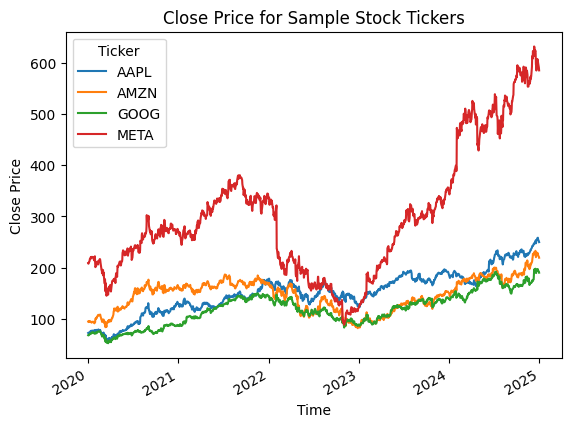

In [ ]:
ax = df.plot.line(xlabel="Time", ylabel="Close Price")
ax.set_title("Close Price for Sample Stock Tickers")
plt.show()

## 1. Historical VaR and CVaR

**Historical simulation** uses actual past returns to estimate risk. We sort the portfolio’s historical daily returns, identify the return at the chosen confidence level (e.g., the 5th percentile for 95% VaR), and compute:

- **VaR** as the negative of that percentile return.
- **CVaR** as the average of all returns worse than VaR, giving insight into tail losses beyond the cutoff.


In [ ]:
initial_portfolio = 100000

returns = df.pct_change()

weights = np.full((4), 0.25)
port_returns = (weights * returns).sum(axis=1)

confidence_level = 0.95
var = port_returns.quantile(q=1 - confidence_level)
cvar = port_returns[port_returns <= var].mean()

var_value = var * initial_portfolio
cvar_value = cvar * initial_portfolio

print(
    f"Historical VaR at {confidence_level} confidence level: {var_value:.2f} ({var:.2%})"
)
print(
    f"Historical CVaR at {confidence_level} confidence level: {cvar_value:.2f} ({cvar:.2%})"
)

Historical VaR at 0.95 confidence level: -3109.58 (-3.11%)
Historical CVaR at 0.95 confidence level: -4465.52 (-4.47%)


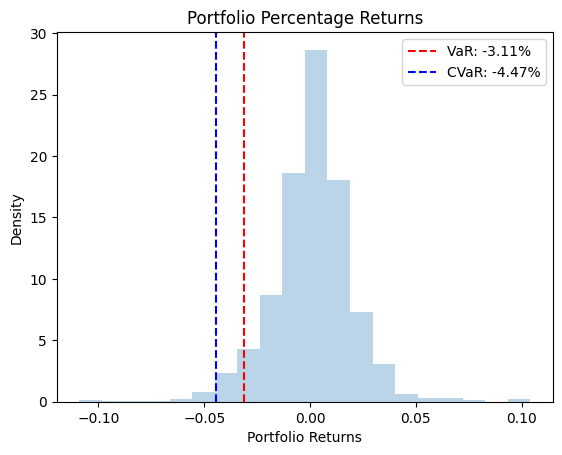

In [ ]:
plt.hist(port_returns, bins=20, density=True, alpha=0.3)

plt.axvline(x=var, color="red", linestyle="--", label=f"VaR: {var:.2%}")
plt.axvline(x=cvar, color="blue", linestyle="--", label=f"CVaR: {cvar:.2%}")

plt.legend()
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## 2. Parametric VaR and CVaR

**Parametric** (variance-covariance) methods assume returns follow a known distribution—typically Normal.

- **VaR** is calculated as $-\mu + z_{\alpha}\,\sigma$, where $z_{\alpha}$ is the standard Normal quantile.
- **CVaR** under Normality can be derived analytically as $\mu + \sigma\,\frac{\varphi(z_{\alpha})}{1-\alpha}$, reflecting the expected shortfall beyond the VaR threshold.


In [ ]:
initial_portfolio = 100000

returns = df.pct_change()

mean_returns = returns.mean()
cov_matrix = returns.cov()

weights = np.full((4), 0.25)
port_mean_return = (weights * mean_returns).sum()
port_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

confidence_level = 0.95
z_score = norm.ppf(q=1 - confidence_level)
var = -(norm.ppf(confidence_level) * port_std_dev - port_mean_return)
cvar = 1 * (
    port_mean_return - port_std_dev * (norm.pdf(z_score) / (1 - confidence_level))
)

var_initial = initial_portfolio * var
cvar_initial = initial_portfolio * cvar

print(
    f"Parametric VaR at {confidence_level} confidence level: {var_initial:.2f} ({var:.2%})"
)
print(
    f"Parametric CVaR at {confidence_level} confidence level: {cvar_initial:.2f} ({cvar:.2%})"
)

Parametric VaR at 0.95 confidence level: -3062.91 (-3.06%)
Parametric CVaR at 0.95 confidence level: -3868.68 (-3.87%)


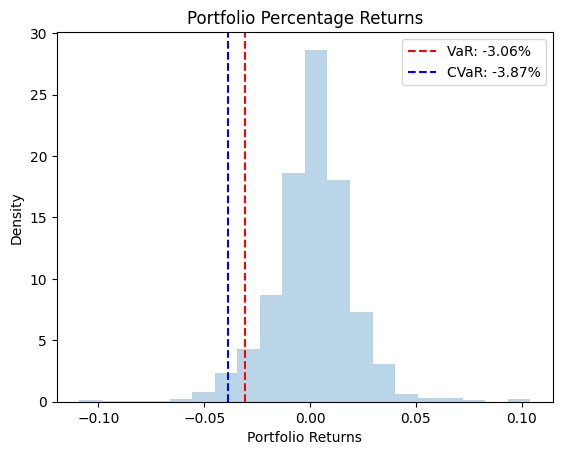

In [ ]:
plt.hist(port_returns, bins=20, density=True, alpha=0.3)

plt.axvline(x=var, color="red", linestyle="--", label=f"VaR: {var:.2%}")
plt.axvline(x=cvar, color="blue", linestyle="--", label=f"CVaR: {cvar:.2%}")

plt.legend()
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## 3. Monte Carlo Simulation


**Monte Carlo** uses random sampling to model future portfolio returns. Steps:

1. Estimate the mean vector and covariance matrix of asset returns.
2. Generate a large number of simulated return scenarios from a multivariate distribution (e.g., Normal).
3. Compute portfolio returns under each scenario.
4. Derive VaR by sorting simulated returns and taking the appropriate percentile, and CVaR as the average of the worst outcomes.


In [ ]:
np.random.seed(10000)

initialPortfolio = 100000

n_simulation = 400
T = 252
weights = np.full((4), 0.25)
meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns).T

sim_pct_change = np.full(shape=(T, n_simulation), fill_value=0.0)
for n_sim in range(n_simulation):
    normal_dist = np.random.normal(size=(T, len(weights)))
    l_matrix = np.linalg.cholesky(cov_matrix)

    daily_pct_change = meanM + np.inner(l_matrix, normal_dist)
    sim_pct_change[:, n_sim] = np.inner(weights, daily_pct_change.T)

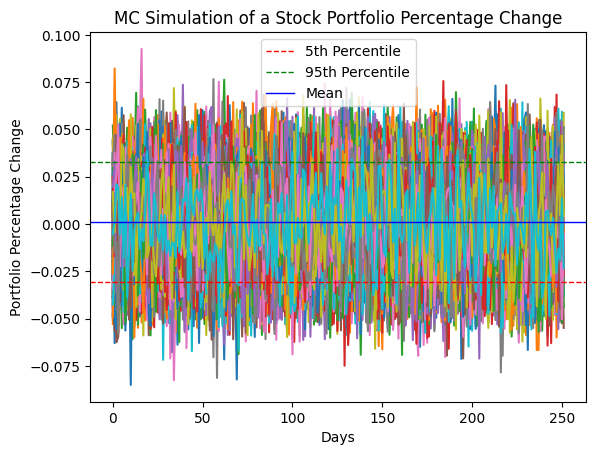

In [ ]:
plt.plot(sim_pct_change)

plt.axhline(
    np.percentile(sim_pct_change, 5),
    color="r",
    linestyle="dashed",
    linewidth=1,
    label="5th Percentile",
)
plt.axhline(
    np.percentile(sim_pct_change, 95),
    color="g",
    linestyle="dashed",
    linewidth=1,
    label="95th Percentile",
)
plt.axhline(
    np.mean(sim_pct_change), color="b", linestyle="solid", linewidth=1, label="Mean"
)

plt.legend()
plt.ylabel("Portfolio Percentage Change")
plt.xlabel("Days")
plt.title("MC Simulation of a Stock Portfolio Percentage Change")
plt.show()

In [ ]:
confidence_level = 0.95
port_pct_change = pd.Series(sim_pct_change[-1, :])

mcVAR = port_pct_change.quantile(1 - confidence_level)
mcCVAR = port_pct_change[port_pct_change <= mcVAR].mean()

portfolio_returns = np.full(shape=(T, n_simulation), fill_value=0.0)

for n_sim in range(n_simulation):
    portfolio_returns[:, n_sim] = (
        np.cumprod(sim_pct_change[:, n_sim] + 1) * initialPortfolio
    )

last_portfolio_returns = portfolio_returns[-1, :]
mc_var_returns = np.percentile(last_portfolio_returns, 5)
mc_cvar_returns = last_portfolio_returns[
    last_portfolio_returns <= mc_var_returns
].mean()

print(f"Monte Carlo VAR at 95% confidence level: ${mc_var_returns:.2f} ({mcVAR:.2%})")
print(
    f"Monte Carlo CVAR at 95% confidence level: ${mc_cvar_returns:.2f} ({mcCVAR:.2%})"
)

Monte Carlo VAR at 95% confidence level: $76854.37 (-2.71%)
Monte Carlo CVAR at 95% confidence level: $68242.15 (-3.47%)


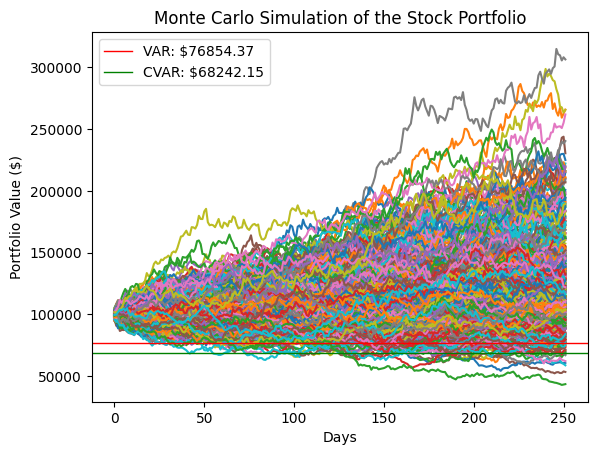

In [ ]:
plt.plot(portfolio_returns)

plt.axhline(mc_var_returns, color="r", linewidth=1, label=f"VAR: ${mc_var_returns:.2f}")
plt.axhline(
    mc_cvar_returns, color="g", linewidth=1, label=f"CVAR: ${mc_cvar_returns:.2f}"
)

plt.legend(loc="upper left")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of the Stock Portfolio")
plt.show()